In [25]:

# 导入库
import time  # 导入时间库
import numpy as np  # 导入numpy库
import pandas as pd  # 导入pandas库
import os
import psycopg2
from sklearn.cluster import KMeans  # 导入sklearn聚类模块
from sklearn import metrics  # 导入sklearn效果评估模块
from sklearn import tree
from sklearn.model_selection import cross_val_score
import pydotplus #提供完整界面，用于计算机处理和过程表
import seaborn as sns


os.chdir('C:\\Users\\Administrator\\Desktop\\')

In [26]:
#图形设置

#解决seaborn中文乱码
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font=FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf",size=16)
sns.set(font='simhei')

from IPython.display import display  # 使得我们可以对DataFrame使用display()函数
from IPython.display import Image


#命令行绘图软体
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin'
#cd C:\\Program Files (x86)\\Graphviz2.38\\bin
#dot -version   查看graphviz安装情况
#

In [27]:
# 读取数据
data = pd.read_csv('data.csv',sep=',',encoding='gbk')  # 读取数据文件

# 1 数据审查和校验

In [28]:
# 数据概览
print ('Data Overview:')
print (data.head())  # 打印原始数据前5条
print ('-' * 60)
print ('Data numbers:')
print (len(data)) # 打印原始数据量
print ('-' * 60)
# 缺失值审查
na_cols = data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
print ('NA Cols:')
print (na_cols)  # 查看具有缺失值的列
print ('-' * 60)
print ('数据总体描述:')
print (data.describe())  # 打印原始数据基本描述性信息
print ("-"*60)
print ('{:*^60}'.format('data dtypes:'))
print (data.dtypes)  # 打印数据类型

Data Overview:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
------------------------------------------------------------
Data numbers:
541909
------------------------------------------------------------
NA Cols:
InvoiceNo      False
StockCode      False
Desc

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


每一笔交易购买的产品数量的最小值是-80995显然是有问题的，对应的最大值也是80995，对于一个网上的零售公司，这应该是退货。
产品单价的最小值也为负数，原因需要后续探究。

In [29]:
#我们需要知道客户的最近交易金额，产品数量和单价都是需要观察确认
data['amount']=data['UnitPrice']*data['Quantity']

In [30]:
# 检查产品单价
Percentile = np.percentile(data['UnitPrice'],[0,25,50,75,100])
IQR = Percentile[3] - Percentile[1]
UpLimit = Percentile[3]+IQR*3
DownLimit = Percentile[1]-IQR*3
print('产品单价异常值上限为：{0}, 下限为：{1}'.format(UpLimit,DownLimit))
print('上限异常值占比：{0} %'.format(data[data['UnitPrice']>12.77].shape[0]*100/data.shape[0]))
print('下限异常值占比：{0} %'.format(data[data['UnitPrice']<0].shape[0]*100/data.shape[0]))
print('产品单价小于0的数据 \n{}'.format(data[data['UnitPrice']<0]))

产品单价异常值上限为：12.77, 下限为：-7.390000000000001
上限异常值占比：2.370877767300414 %
下限异常值占比：0.00036906565493468463 %
产品单价小于0的数据 
       InvoiceNo StockCode      Description  Quantity      InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  8/12/2011 14:51   
299984   A563187         B  Adjust bad debt         1  8/12/2011 14:52   

        UnitPrice  CustomerID         Country    amount  
299983  -11062.06         NaN  United Kingdom -11062.06  
299984  -11062.06         NaN  United Kingdom -11062.06  


产品单价小于0的在描述中说明是坏账，用户的ID也未知，整个数据中的坏账就这一笔，在做RFM模型需要删除

In [31]:
#检查产品交易数量
Percentile = np.percentile(data['Quantity'],[0,25,50,75,100])
IQR = Percentile[3] - Percentile[1]
UpLimit = Percentile[3]+IQR*3
DownLimit = Percentile[1]-IQR*3
print('产品交易数量异常值上限为：{0}, 下限为：{1}'.format(UpLimit,DownLimit))
print('上届异常值占比：{0} %'.format(data[data['Quantity']>37].shape[0]*100/data.shape[0]))
print('下届异常值占比：{0} %'.format(data[data['Quantity']<0].shape[0]*100/data.shape[0]))
print('产品交易小于0的数据量： {}'.format(len(data[data['Quantity']<0])))
print('产品交易数量大于37的数据 {}'.format(len(data[data['Quantity']>37])))

产品交易数量异常值上限为：37.0, 下限为：-26.0
上届异常值占比：3.8224129881585283 %
下届异常值占比：1.9604767590130445 %
产品交易小于0的数据量： 10624
产品交易数量大于37的数据 20714


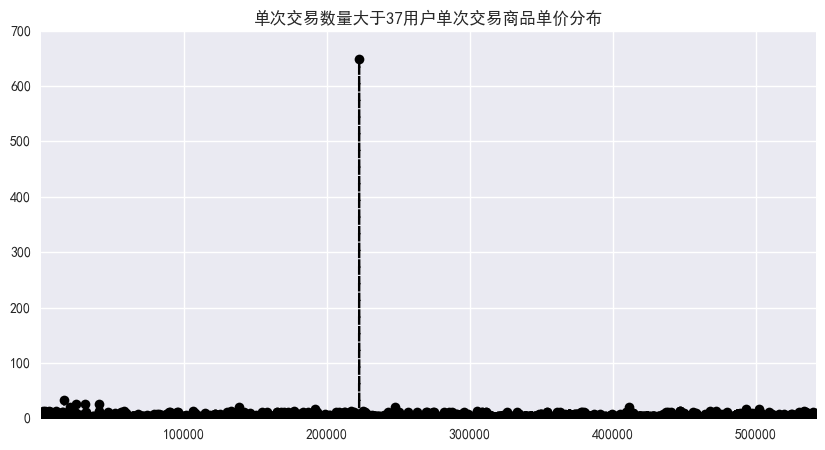

交易数量多且货品单价高的单价为649.5
------------------------------------------------------------
       InvoiceNo StockCode                     Description  Quantity  \
222670    556442     22502      PICNIC BASKET WICKER SMALL        60   
222680    556444     22502  PICNIC BASKET WICKER 60 PIECES        60   
222681   C556445         M                          Manual        -1   
222682    556446     22502  PICNIC BASKET WICKER 60 PIECES         1   
222692   C556448     22502      PICNIC BASKET WICKER SMALL       -60   

            InvoiceDate  UnitPrice  CustomerID         Country   amount  
222670  6/10/2011 15:22       4.95     15098.0  United Kingdom    297.0  
222680  6/10/2011 15:28     649.50     15098.0  United Kingdom  38970.0  
222681  6/10/2011 15:31   38970.00     15098.0  United Kingdom -38970.0  
222682  6/10/2011 15:33     649.50     15098.0  United Kingdom    649.5  
222692  6/10/2011 15:39       4.95     15098.0  United Kingdom   -297.0  
-----------------------------------------

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,amount
CustomerID,,,,,,,,
14911.0,226,226,226,226,226,226,226,226
17841.0,136,136,136,136,136,136,136,136
17511.0,113,113,113,113,113,113,113,113
15311.0,112,112,112,112,112,112,112,112
12607.0,101,101,101,101,101,101,101,101
14410.0,93,93,93,93,93,93,93,93
13798.0,90,90,90,90,90,90,90,90
14606.0,82,82,82,82,82,82,82,82
13113.0,79,79,79,79,79,79,79,79


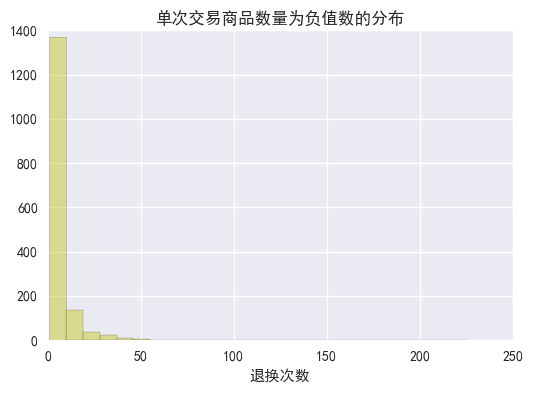

------------------------------------------------------------
交易产品数量为负值的用户数：1589


In [32]:
#单次交易产品数量过多
data[data['Quantity']>37]['UnitPrice'].plot(style = 'k--o',figsize=(10,5),title='单次交易数量大于37用户单次交易商品单价分布')
plt.show()




print('交易数量多且货品单价高的单价为{}'.format(data[data['Quantity']>37]['UnitPrice'].max()))
print ('-' * 60)
print(data[data['CustomerID']==15098])
print ('-' * 60)

#单次产品数量为负
print('交易产品数量为负值的记录数：{}'.format(len(data[data['Quantity']<0])))

a=data[data['Quantity']<0].groupby('CustomerID').count()
q=a.sort_values(by='Description',ascending=False)
display(q.iloc[:10])

b=a.loc[a['Country']>10]
sns.distplot(a['Country'],bins = 25,hist = True,kde = False,norm_hist=False,
           vertical = False,axlabel = '退换次数',
            color = 'y')
plt.title('单次交易商品数量为负值数的分布')
plt.show()
print ('-' * 60)
print('交易产品数量为负值的用户数：{}'.format(len(a)))

编号为15098的用户在10月6好号退换多次产品 野餐筐柳条小，且客户全年的交易都是集中在此。最后用户
买了单价为649元的一件物品,这样的客户在10月以后直到12月1日都没有在平台消费过，是因为这次交易的什么
原因？售后人工退款及时，排除售后原因


交易产品数量为负值的用户数有1589，相比平台一年用户4000+，数量较多，直接删除信息损失大，不删除会导致在构建RFM模型中，F值偏大。考虑删除相应负值记录与对应的正值记录工作量大。查看用户交易产品数为负值的的数据分布图，每个客户一年交易产品数为负值在10以下，几乎。不会影响
模型构建，所以我们选取小于10次的客户数据分析建模。

# 2.整理数据为模型做准备

In [33]:
#整理数据为模型做准备
b.reset_index(inplace=True)
b.CustomerID

for i in b.CustomerID:
    y=data[data['CustomerID']!=i] 
    dtata=y
print(len(data))

541909


In [34]:
model_data=data[data['CustomerID'].notnull()]
len(model_data)

406829

In [35]:
#处理交易发生时间

#df['InvoiceDate'].apply(lambda x:type(x))
model_data['InvoiceDate']=model_data['InvoiceDate'].str.split(' ').str[0]
a=model_data['InvoiceDate'].str.split('/')
model_data['Date']=a.str[-1]+'-'+a.str[0]+'-'+a.str[1]
model_data['Date']=pd.to_datetime(model_data['Date'])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [36]:
deadline_date = pd.datetime(2011,12,10)  # 指定一个时间节点，用于计算其他时间与该时间的距离
model_data['r_interval'] = (deadline_date - model_data['Date']).dt.days  # 计算R间隔

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [37]:
#选择近3个月的数据
model_data=model_data[model_data['r_interval']<90]

In [38]:
len(model_data)

162670

# 3. 基于k均值的RFM模型的构建

************************************************************************************************************************


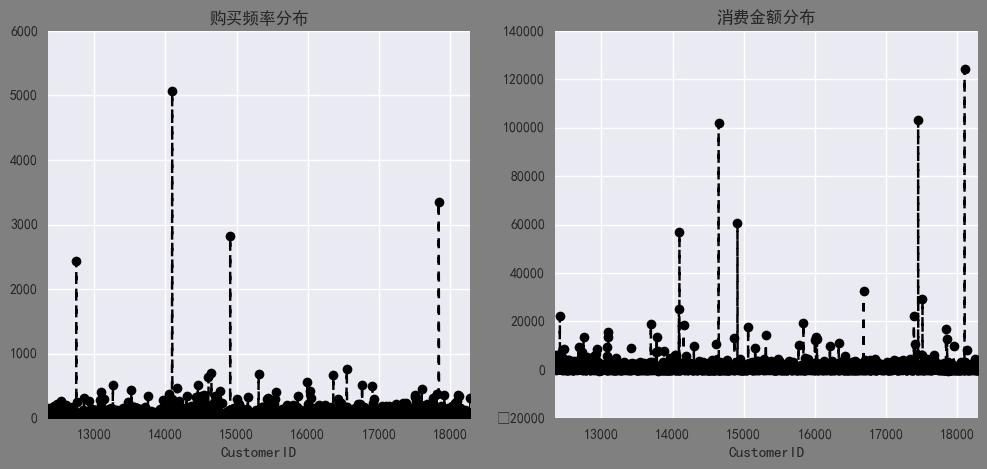

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,amount,Date,r_interval
CustomerID,,,,,,,,,,
14096.0,5065,5065,5065,5065,5065,5065,5065,5065,5065,5065
17841.0,3357,3357,3357,3357,3357,3357,3357,3357,3357,3357
14911.0,2819,2819,2819,2819,2819,2819,2819,2819,2819,2819
12748.0,2431,2431,2431,2431,2431,2431,2431,2431,2431,2431


,Quantity,UnitPrice,amount,r_interval
CustomerID,,,,
18102.0,32651,1089.63,124206.55,15883
17450.0,36858,638.24,103091.11,7808
14646.0,69171,2036.23,101903.40,33217
14911.0,36420,11128.43,60507.06,125808
14096.0,16242,41031.14,57017.25,202668


************************************************************************************************************************


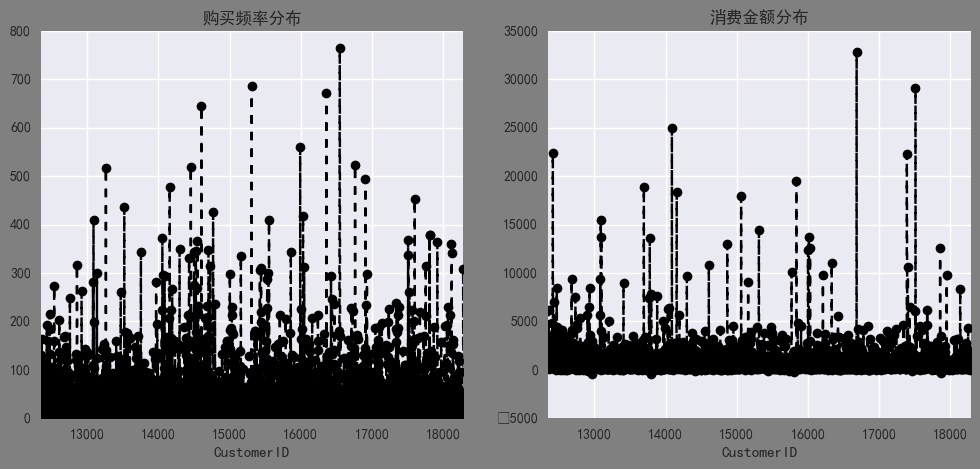

,Quantity,UnitPrice,amount,r_interval
CustomerID,,,,
16684.0,25770,235.12,32770.06,4526
17511.0,22844,725.02,29094.49,12172
14088.0,5591,1641.13,24983.92,9195
12415.0,10768,593.36,22389.92,6384
17389.0,5670,450.49,22329.60,3246
15838.0,10370,130.57,19489.58,3283
13694.0,14286,435.54,18846.10,5470
14156.0,8968,878.85,18353.23,8413
15061.0,9691,288.97,17899.74,4281


In [39]:
#RFM模型的构建
recency_value = model_data.groupby('CustomerID')['Date'].max()# 计算原始最近一次订单时间
frequency_value =model_data.groupby('CustomerID')['Date'].count()  # 计算原始订单频率
monetary_value = model_data.groupby('CustomerID')['amount'].sum()  # 计算原始订单总金额

#使用极值等间距分位发现F和M的值基本都集中在1分的位置，这样由于数据中有异常值的影响我们对用户不能做到细分，所以根据下图，我们
#可以取频率最多值为90，消费金额最大值为20000。异常的用户需要进一步查看，针对性处理。
fig = plt.figure(figsize=(12,5),facecolor = 'gray')
ax1 = fig.add_subplot(1,2,1)  
frequency_value.plot(style = 'k--o',ax=ax1)
plt.title('购买频率分布')

print('*'*120)

ax2= fig.add_subplot(1,2,2)
monetary_value.plot(style = 'k--o',ax=ax2)
plt.title('消费金额分布')
plt.show()

display((model_data.groupby('CustomerID').count().sort_values(by = 'Date',ascending=False).iloc[:4]))
display(model_data.groupby('CustomerID').sum().sort_values(by ='amount',ascending=False).iloc[:5])


#选择过滤数据
model_data_final=model_data[(model_data.CustomerID!=14096)&(model_data.CustomerID!=17841)&(model_data.CustomerID!=14911)&(model_data.CustomerID!=18102)&(model_data.CustomerID!=17450)&(model_data.CustomerID!=14646)&(model_data.CustomerID!=14096)&(model_data.CustomerID!=12748)]



#再次审视数据
#RFM模型的构建
recency_value = model_data_final.groupby('CustomerID')['Date'].max()# 计算原始最近一次订单时间
frequency_value =model_data_final.groupby('CustomerID')['Date'].count()  # 计算原始订单频率
monetary_value = model_data_final.groupby('CustomerID')['amount'].sum()  # 计算原始订单总金额



#使用极值等间距分位发现F和M的值基本都集中在1分的位置，这样由于数据中有异常值的影响我们对用户不能做到细分，所以根据下图，我们
#可以取频率最多值为90，消费金额最大值为20000。异常的用户需要进一步查看，针对性处理。
fig = plt.figure(figsize=(12,5),facecolor = 'gray')
ax1 = fig.add_subplot(1,2,1)  
frequency_value.plot(style = 'k--o',ax=ax1)
plt.title('购买频率分布')

print('*'*120)

ax2= fig.add_subplot(1,2,2)
monetary_value.plot(style = 'k--o',ax=ax2)
plt.title('消费金额分布')
plt.show()



#处理后3个月的消费金额 仍然消费差距仍然很大，我们还要处理
display(model_data_final.groupby('CustomerID').sum().sort_values(by ='amount',ascending=False).iloc[:12])



m=model_data_final.groupby('CustomerID').sum().sort_values(by ='amount',ascending=False).iloc[:10].index
k=model_data_final.groupby('CustomerID').count().sort_values(by ='Date',ascending=False).iloc[:8].index



for i in m:
    y=model_data_final[model_data_final['CustomerID']!=i]
    model_data_final=y
    #print(len(model_data_final))
#model_data_final=y


for i in k:
    y=model_data_final[model_data_final['CustomerID']!=i]
    model_data_final=y
    #print(len(model_data_final))

RFM Score Overview:
            r_score  f_score  m_score
CustomerID                           
12347.0           5        1        1
12348.0           1        1        1
12349.0           4        1        1
12352.0           3        1        1
------------------------------------------------------------


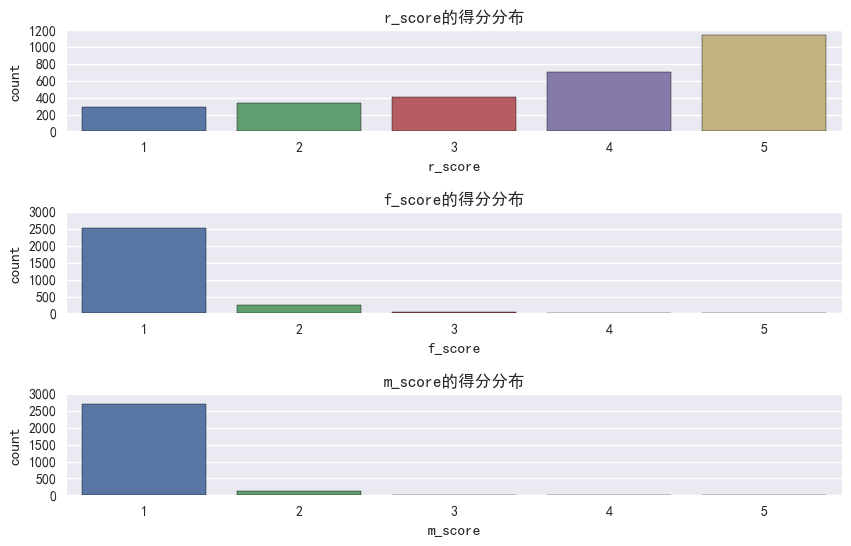

Final RFM Scores Overview:
            r_score  f_score  m_score rfm_comb
CustomerID                                    
12347.0           5        1        1      511
12348.0           1        1        1      111
12349.0           4        1        1      411
12352.0           3        1        1      311
------------------------------
Final deescribe:
           r_score      f_score      m_score
count  2879.000000  2879.000000  2879.000000
mean      3.724904     1.163598     1.085446
std       1.349616     0.507062     0.387865
min       1.000000     1.000000     1.000000
25%       3.000000     1.000000     1.000000
50%       4.000000     1.000000     1.000000
75%       5.000000     1.000000     1.000000
max       5.000000     5.000000     5.000000


In [40]:
#RFM模型的重新构建
recency_value = model_data_final.groupby('CustomerID')['Date'].max()# 计算原始最近一次订单时间
frequency_value =model_data_final.groupby('CustomerID')['Date'].count()  # 计算原始订单频率
monetary_value = model_data_final.groupby('CustomerID')['amount'].sum()  # 计算原始订单总金额



# 计算RFM得分，极值分位法分组
# 分别计算R、F、M得分
deadline_date = pd.datetime(2011,12,10)  # 指定一个时间节点，用于计算其他时间与该时间的距离
r_interval = (deadline_date - recency_value).dt.days  # 计算R间隔
r_score = pd.cut(r_interval, 5, labels=[5,4,3, 2, 1])  # 计算R得分
f_score = pd.cut(frequency_value, 5, labels=[1, 2, 3,4,5])  # 计算F得分
m_score= pd.cut(monetary_value, 5, labels=[1, 2, 3,4,5])  # 计算M得分



# R、F、M数据合并
rfm_list = [r_score, f_score, m_score]  # 将r、f、m三个维度组成列表
rfm_cols = ['r_score', 'f_score', 'm_score']  # 设置r、f、m三个维度列名
rfm_pd = pd.DataFrame(np.array(rfm_list).T, dtype=np.int32, columns=rfm_cols,index=frequency_value.index)  # 建立r、f、m数据框
print ('RFM Score Overview:')
print (rfm_pd.head(4))
print ('-' * 60)



fig=plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(3,1,1)
sns.countplot(rfm_pd['r_score'],data=rfm_pd)
plt.title('r_score的得分分布')


ax2 = fig.add_subplot(3,1,2)
sns.countplot(rfm_pd['f_score'],data=rfm_pd)
plt.title('f_score的得分分布')

ax3= fig.add_subplot(3,1,3)
sns.countplot(rfm_pd['m_score'],data=rfm_pd)
plt.title('m_score的得分分布')

plt.subplots_adjust(wspace=0,hspace=0.8)#调整图形间距
plt.show()

# 计算RFM总得分
# 方法一：加权得分
#rfm_pd['rfm_wscore'] = rfm_pd['r_score'] * 0.6 + rfm_pd['f_score'] * 0.3 + rfm_pd['m_score'] * 0.1
# 方法二：RFM组合
rfm_pd_tmp = rfm_pd.copy()
rfm_pd_tmp['r_score'] = rfm_pd_tmp['r_score'].astype('str')
rfm_pd_tmp['f_score'] = rfm_pd_tmp['f_score'].astype('str')
rfm_pd_tmp['m_score'] = rfm_pd_tmp['m_score'].astype('str')
rfm_pd['rfm_comb'] = rfm_pd_tmp['r_score'].str.cat(rfm_pd_tmp['f_score']).str.cat(rfm_pd_tmp['m_score'])#cat()连接字符串 


# 打印输出和保存结果
# 打印结果
print ('Final RFM Scores Overview:')
print (rfm_pd.head(4))  # 打印数据前4项结果
print ('-' * 30)
print ('Final deescribe:')
print (rfm_pd.describe())


# 4.Kmeans聚类模型

平均轮廓系数为0.8745172067987853


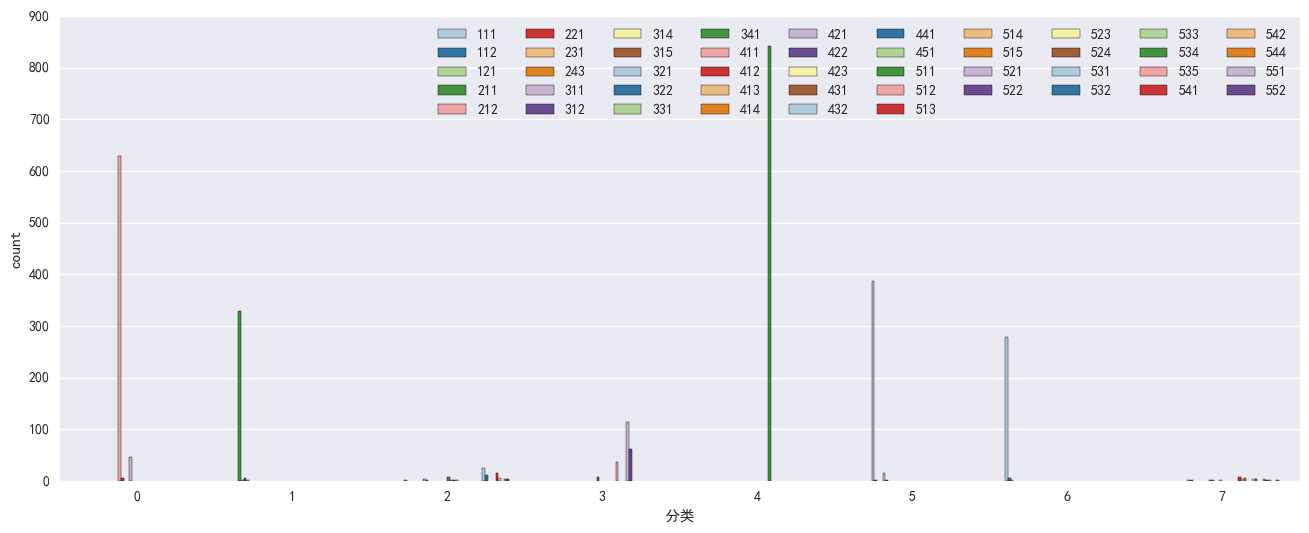

活跃新用户     841
一般活跃用户    680
一般用户      405
一般维持用户    336
流失用户      284
重要价值用户    219
潜力用户       77
重要深耕用户     37
Name: 客户类型, dtype: int64


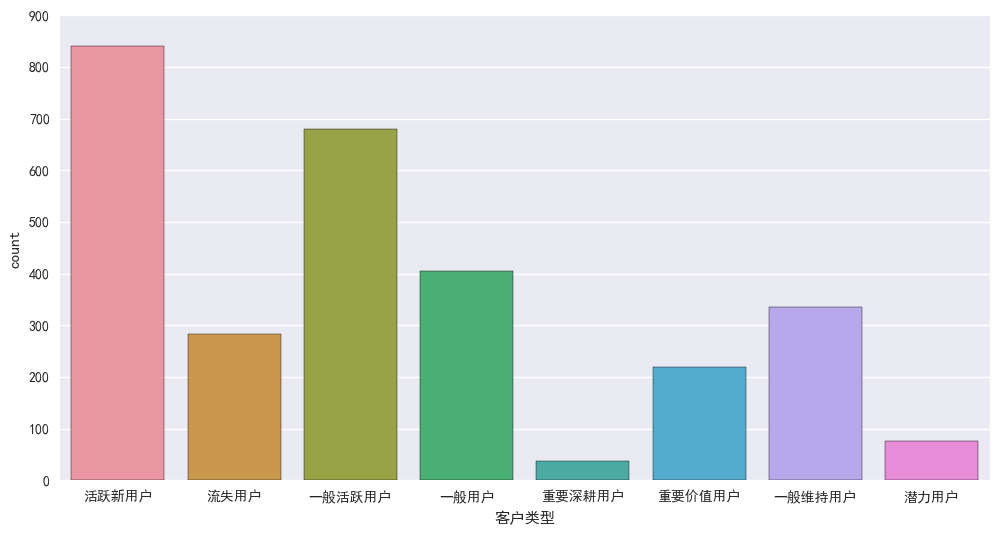

In [41]:
#聚类建模

# 1）数据准备
X = rfm_pd[['r_score', 'f_score', 'm_score']]  # 分割要聚类的数据
y_true = rfm_pd['rfm_comb']



# 训练聚类模型
n_clusters = 8  # 设置聚类数量
model_kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # 建立聚类模型对象
model_kmeans.fit(X)  # 训练聚类模型
y_pre = model_kmeans.predict(X)  # 预测聚类模型

silhouette_s = metrics.silhouette_score(X, y_pre, metric='euclidean')  # 平均轮廓系数
print ('平均轮廓系数为{}'.format(silhouette_s))
#平均轮廓系数是分离度与凝聚度之差与分离度和凝聚度的最大值之比，值在-1-1之间，轮廓系数越接近于1聚类效果越好。

#得到聚类结果
rfm_pd['分类']=y_pre


# 保存RFM得分到本地文件
rfm_pd.to_csv('sales_rfm_score.csv')  # 保存数据为csv


fig=plt.figure(figsize=(16,6))
sns.countplot(x="分类", hue="rfm_comb", data=rfm_pd,palette = 'Paired')
plt.legend(loc = 'upper right',ncol=10) 
#plt.text(1.,10,512)
plt.show()

rfm_pd.loc[rfm_pd['分类']==0,'客户类型']='一般活跃用户'
rfm_pd.loc[rfm_pd['分类']==1,'客户类型']='一般维持用户'
rfm_pd.loc[rfm_pd['分类']==2,'客户类型']='潜力用户'
rfm_pd.loc[rfm_pd['分类']==3,'客户类型']='重要价值用户'
rfm_pd.loc[rfm_pd['分类']==4,'客户类型']='活跃新用户'
rfm_pd.loc[rfm_pd['分类']==5,'客户类型']='一般用户'
rfm_pd.loc[rfm_pd['分类']==6,'客户类型']='流失用户'
rfm_pd.loc[rfm_pd['分类']==7,'客户类型']='重要深耕用户'

print(rfm_pd['客户类型'].value_counts())

fig=plt.figure(figsize=(12,6))
sns.countplot("客户类型", data=rfm_pd)
plt.show()

In [42]:
'''
print(rfm_pd['r_score'].mean())
print(rfm_pd['f_score'].mean())
print(rfm_pd['m_score'].mean())
rfm_pd[rfm_pd['分类']==1]
'''

"\nprint(rfm_pd['r_score'].mean())\nprint(rfm_pd['f_score'].mean())\nprint(rfm_pd['m_score'].mean())\nrfm_pd[rfm_pd['分类']==1]\n"

# 4.使用决策树检验和信息查询

In [43]:
#决策树分类价值用户，也可以通过周期的查看指标值了解客户的价值评估标准，结合近期活动，查看分析是不是达到效果。

#准备数据

c=model_data_final.groupby('CustomerID').agg(['count'])['r_interval']#计算频次
d=model_data_final.groupby('CustomerID').agg(['sum'])['amount']#计算近期消费金额
e=model_data_final.groupby('CustomerID').agg(['min'])['r_interval']#计算近期消费金额
model_data_tree1=pd.merge(c,rfm_pd,left_index=True,right_index=True,how='right')#匹配用户近期购物次数信息
model_data_tree2=pd.merge(d,model_data_tree1,left_index=True,right_index=True,how='right')#匹配用户近期消费金额信息
model_data_tree3=pd.merge(e,model_data_tree2,left_index=True,right_index=True,how='right')#匹配近期购物时间距离
treedata=model_data_tree3[['min', 'count', 'sum','客户类型']]

column=({'min':'最后一次消费时间距今距离',
        'count':'三个月消费次数',
        'sum':'三个月消费金额',
        '客户类型':'客户类型'})
treedata.rename(columns=column,inplace=True)


#训练函数
clf = tree.DecisionTreeClassifier(max_leaf_nodes=8)
X=treedata[['最后一次消费时间距今距离','三个月消费次数','三个月消费金额']]
y=treedata['客户类型']
clf = clf.fit(X,y)

#交叉验证
cross_val_score(clf,X,y,cv=10)
#效果不错

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


array([ 0.97938144,  0.98275862,  0.98275862,  0.97931034,  0.97577855,
        0.97222222,  0.97560976,  0.9754386 ,  0.9754386 ,  0.98239437])

In [50]:
treedata['客户类型'].value_counts()

活跃新用户     841
一般活跃用户    680
一般用户      405
一般维持用户    336
流失用户      284
重要价值用户    219
潜力用户       77
重要深耕用户     37
Name: 客户类型, dtype: int64

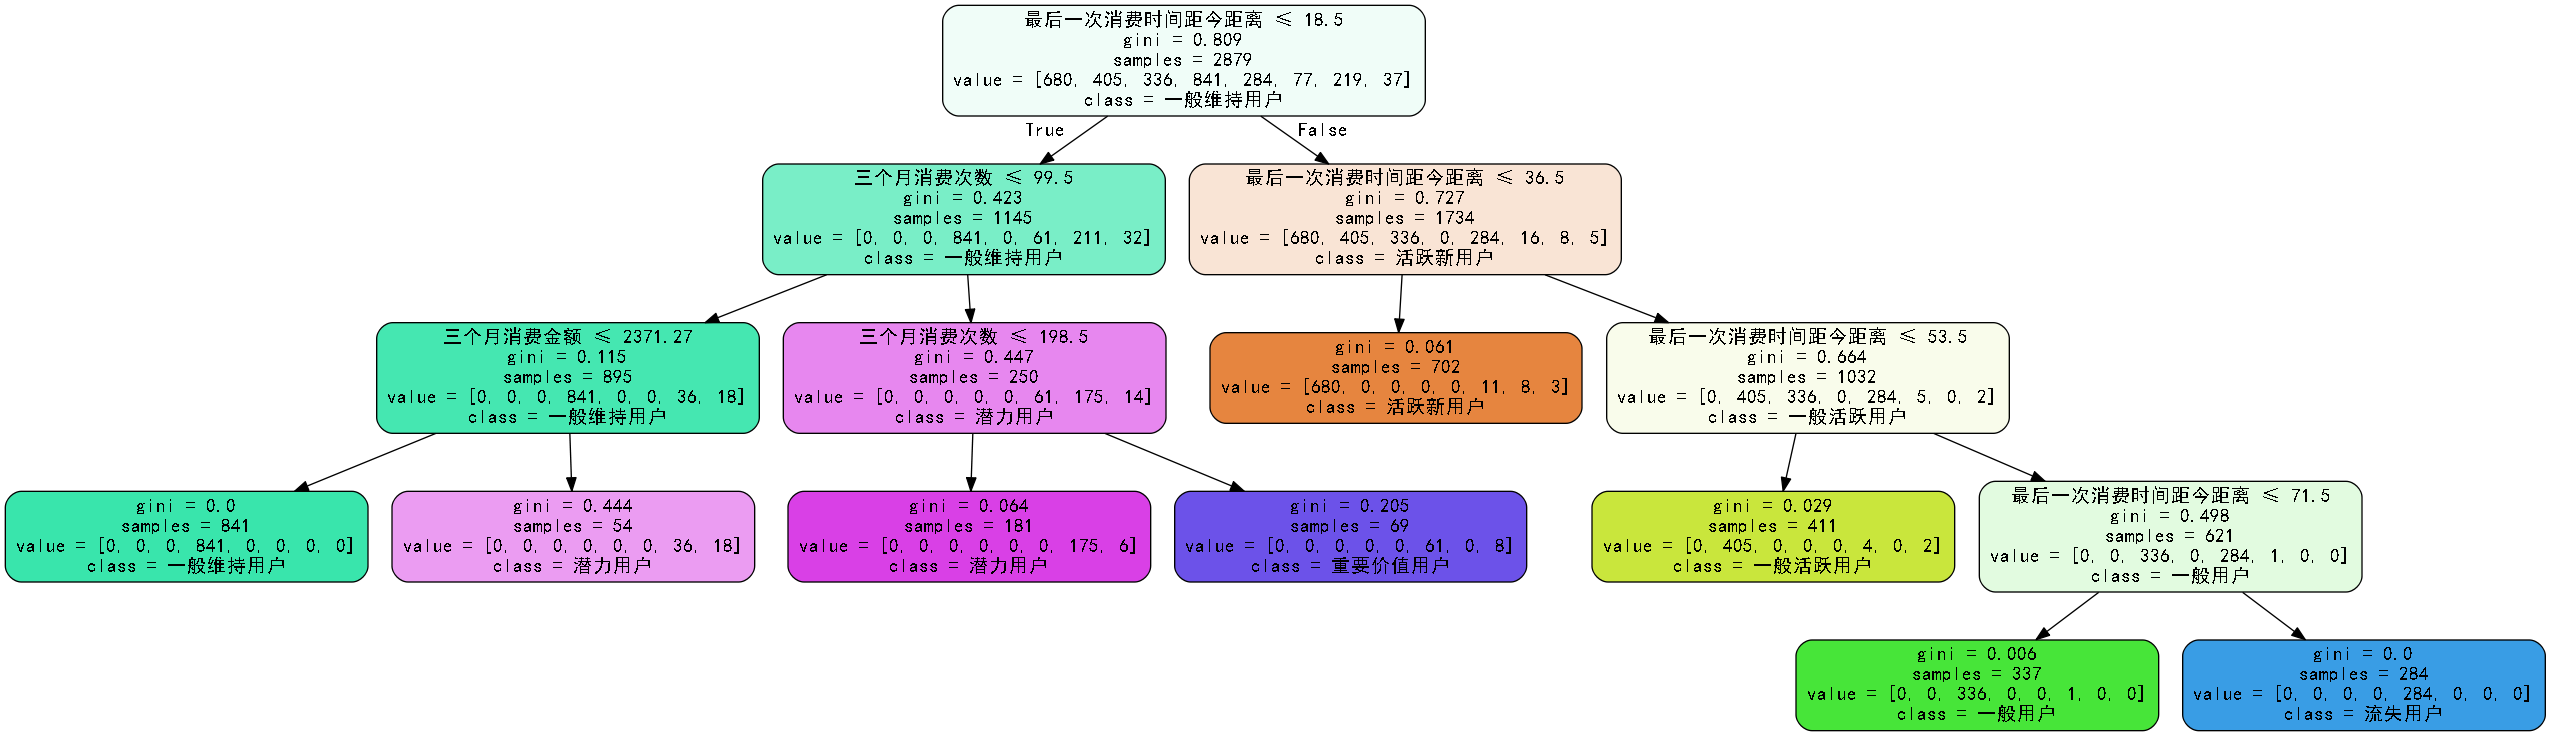

' clf:   决策树模型\n    out_file  图形输出路径\n    class_names 目标属性特征，一般用于中文\n    filled=True：是否用颜色填充\n    round  边框是否采用圆角边框\n    special_characters  是否有特殊字符\n'

In [51]:
#保存dot_data文件

from sklearn.externals.six import StringIO
dot_data=StringIO()
tree.export_graphviz(clf, out_file=dot_data,
                    feature_names=['最后一次消费时间距今距离','三个月消费次数','三个月消费金额'], 
                    class_names=['活跃新用户','一般活跃用户','一般用户','一般维持用户','流失用户','重要价值用户','潜力用户','重要深耕用户']
                    ,filled=True, rounded=True,  
                    special_characters=True) #对应treedata的类顺序

graph = pydotplus.graph_from_dot_data(dot_data.getvalue().replace('helvetica',"simhei"))  
graph.write_png('dot_data.png')
a=Image(graph.create_png())
display(a)

''' clf:   决策树模型
    out_file  图形输出路径
    class_names 目标属性特征，一般用于中文
    filled=True：是否用颜色填充
    round  边框是否采用圆角边框
    special_characters  是否有特殊字符
'''


In [ ]:
'''
#保存dot_data文件
with open ('dot_data','w') as  f:
    f.writelines(dot_data)


#编码转utf8编码
import codecs
txt_dir = 'dot_data.txt'
txt_dir_utf8 = 'dot_data_utf8.txt'

with codecs.open(txt_dir, 'r') as f, codecs.open(txt_dir_utf8, 'w', encoding='utf-8') as wf:
    for line in f:
        lines = line.strip().split('\t')
        print(lines)
        if 'label' in lines[0]:
            newline = lines[0].replace('\n', '').replace(' ', '')
        else:
            newline = lines[0].replace('\n','').replace('SimSun-ExtB', 'Microsoft YaHei')
        wf.write(newline + '\t')
        
'''